In [1]:
import pydicom as dicom
from glob import glob

import numpy as np
import scipy
import cv2
from sklearn.metrics import mean_squared_error

import matplotlib.pylab as plt
from tqdm import tqdm

**Raw Image**

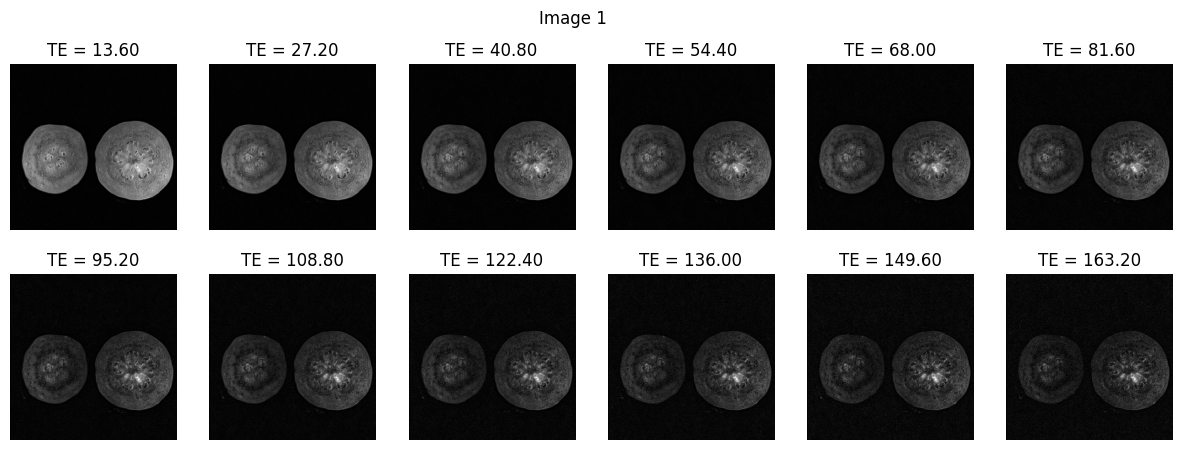

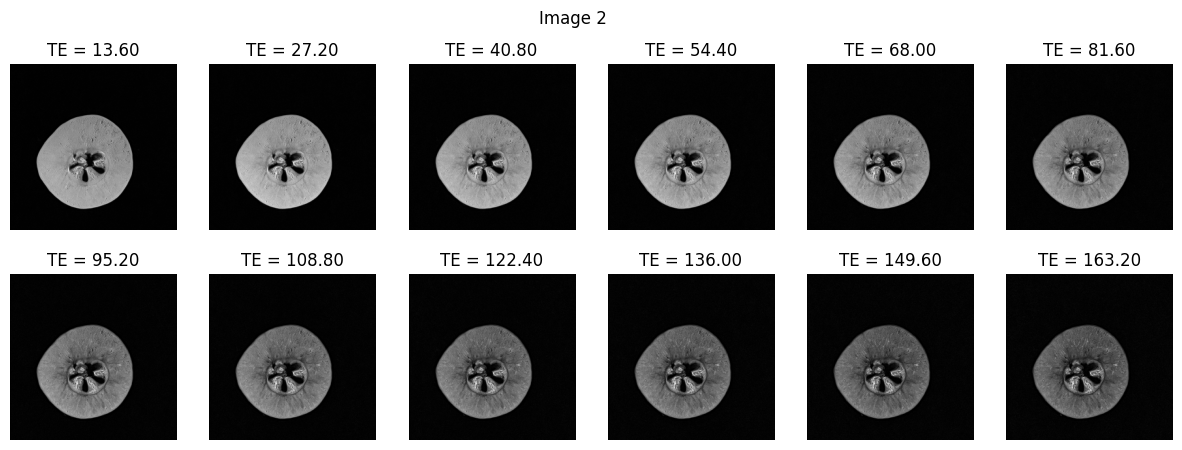

In [2]:
image_fns = glob(r'012_se_mc\*.dcm')
image_ff_1 = list()
images_1 = list()
TEs_1 = list()

image_ff_2 = list()
images_2 = list()
TEs_2 = list()

for i, ff in enumerate(image_fns):
    if i % 2 == 0:
        image_ff_1.append(ff)
    else:
        image_ff_2.append(ff)

# image 1
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
for idx, ff in enumerate(image_ff_1):
    ds = dicom.dcmread(ff)
    image = ds.pixel_array
    TE = float(ds['EchoTime'].value)
    
    ax[idx//6][idx%6].set_title(f'TE = {TE:.2f}')
    ax[idx//6][idx%6].imshow(image, cmap='gray')
    ax[idx//6][idx%6].axis('off')
    
    images_1.append(image)
    TEs_1.append(TE)
    
fig.suptitle('Image 1')
plt.savefig('image1_display.jpg')
plt.show()

# image 2
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
for idx, ff in enumerate(image_ff_2):
    ds = dicom.dcmread(ff)
    image = ds.pixel_array
    TE = float(ds['EchoTime'].value)
    
    ax[idx//6][idx%6].set_title(f'TE = {TE:.2f}')
    ax[idx//6][idx%6].imshow(image, cmap='gray')
    ax[idx//6][idx%6].axis('off')
    
    images_2.append(image)
    TEs_2.append(TE)
    
fig.suptitle('Image 2')
plt.savefig('image2_display.jpg')
plt.show()

In [4]:
images_1 = np.array(images_1)
TEs_1 = np.array(TEs_1)
images_2 = np.array(images_2)
TEs_2 = np.array(TEs_2)

def func1(TE, T2_inv):
    return images_1.max() * np.exp(-TE * 1e-3 * T2_inv)

def func2(TE, T2):
    return images_1[0, x, y] * np.exp((TEs_1[0] - TE) / (T2 * 1000))

**Preprocessing**

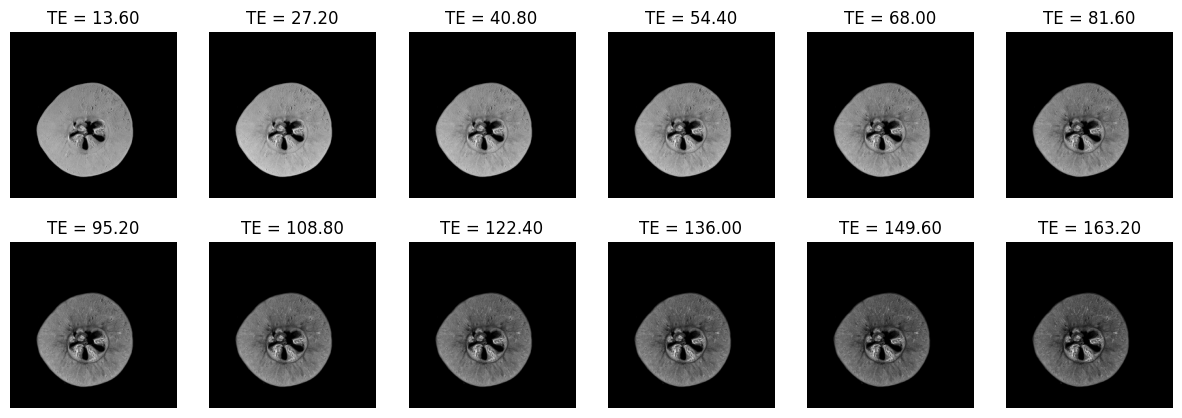

In [14]:
def low_mean_to_zero(raw_data, limit):
    data = raw_data.copy()
    for x in range(data.shape[1]):
        for y in range(data.shape[2]):
            mean = data[:, x, y].mean()
            if mean < limit:
                data[:, x, y] = 0
#                 data[:, x, y] = data[:, x, y].mean()
                
    return data

def low_std_to_zero(raw_data, limit):
    data = raw_data.copy()
    for x in range(data.shape[1]):
        for y in range(data.shape[2]):
            std = data[:, x, y].std()
            if std < limit:
                data[:, x, y] = 0
#                 data[:, x, y] = data[:, x, y].mean()
                
    return data

data = images_2
te = TEs_2
image = data
# image = cv2.blur(data, (3, 3))
# image = cv2.medianBlur(data, 3)
# image = cv2.GaussianBlur(data, (3, 3), 0)

image = low_mean_to_zero(data, 100)
# image = low_std_to_zero(data, 100)



fig, ax = plt.subplots(2, 6, figsize=(15, 5))
for idx in range(image.shape[0]):    
    ax[idx//6][idx%6].set_title(f'TE = {te[idx]:.2f}')
    ax[idx//6][idx%6].imshow(image[idx], cmap='gray')
    ax[idx//6][idx%6].axis('off')

[1.0000013]
RMSE = 0.001
0.0


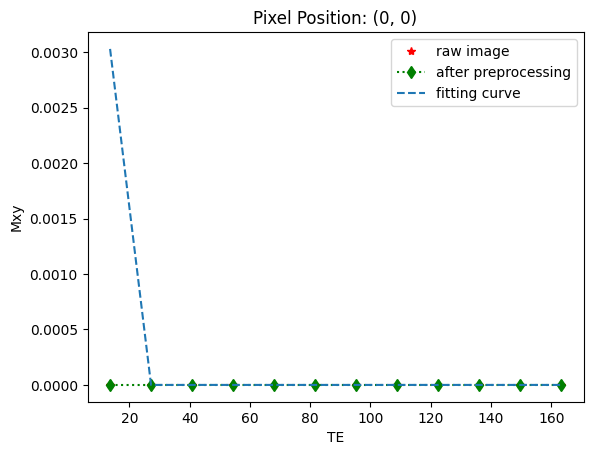

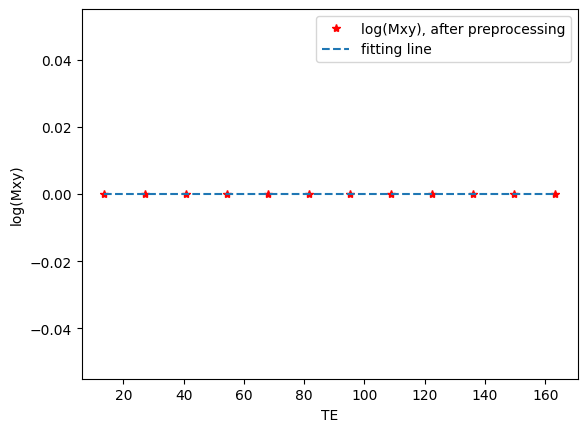

In [15]:
# x, y = 1, 1
x, y = 0, 0
# x, y = 200, 200

# curve fit
func = func1
popt, pcov = scipy.optimize.curve_fit(func, te, image[:, x, y], bounds=(0, [1000]))
preds = np.array(func(te, *popt))
print(1000/popt)

# linear regression
# res = scipy.stats.linregress(te, np.log(image[:, x, y] + 1))
# preds = np.exp(res.intercept + res.slope*te)
# print(image[:, x, y])
# print(res.intercept, res.slope, -1/(res.slope))
# print(preds)
# print(-1/(res.slope) if -res.slope > 0.00625 else 0)

# linear regression only fit T2
# res = scipy.stats.linregress(te[0] - te, np.log(image[:, x, y]))
# preds = np.exp(np.log(image[0, x, y]) + res.slope*(te[0] - te))

RMSE = mean_squared_error(data[:, x, y], preds, squared=False)
print(f'RMSE = {RMSE:.3f}')
print(data[:, x, y].std())

plt.plot(te, data[:, x, y], 'r*')
plt.plot(te, image[:, x, y], 'g:d')
plt.plot(te, preds, '--')
plt.title(f'Pixel Position: ({x}, {y})')
plt.xlabel('TE')
plt.ylabel('Mxy')
plt.legend(['raw image', 'after preprocessing', 'fitting curve'])
plt.show()

plt.plot(te, np.log(image[:, x, y] + 1), 'r*')
plt.plot(te, res.intercept + res.slope*te, '--')
plt.legend(['log(Mxy), after preprocessing', 'fitting line'])
plt.xlabel('TE')
plt.ylabel('log(Mxy)')
plt.show()

In [16]:
loss = 0
cnt = 0
T2_map = np.empty((256, 256))
for x in tqdm(range(256)):
    for y in range(256):
#         func = func1
#         popt, pcov = scipy.optimize.curve_fit(func, te, image[:, x, y], bounds=(0, [1000]))
#         preds = np.array(func(te, *popt))
    
        res = scipy.stats.linregress(te, np.log(image[:, x, y] + 1))
        preds = np.exp(res.intercept + res.slope*te)
        if -res.slope > 0.00625:
            T2_map[x, y] = -1/(res.slope)
            
            loss += mean_squared_error(data[:, x, y], preds, squared=False)
            cnt += 1
        else:
            T2_map[x, y] = 0
            
        

loss /= cnt

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:08<00:00, 30.48it/s]


In [17]:
print(f'{loss:.3f}', cnt)

59.567 15655


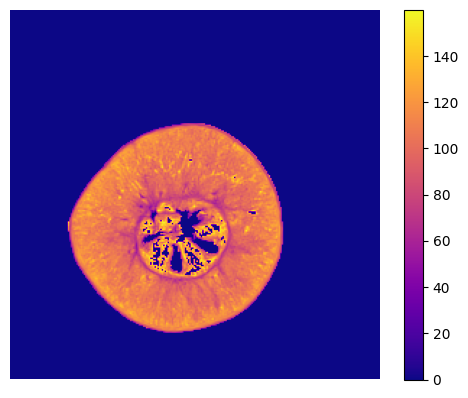

In [18]:
# plt.title(f'{loss:.3f}')
plt.imshow(T2_map, cmap='plasma')
plt.axis('off')
plt.colorbar()
plt.show()